    DROP DATABASE IF EXISTS datos_padron CASCADE;

### Creacion de tablas en formato texto

**1.1)  Crear Base de datos "datos_padron".**

    CREATE DATABASE datos_padron;
    use datos_padron;


**1.2)  Crear la tabla de datos padron_txt con todos los campos del fichero CSV y cargar los datos mediante el comando LOAD DATA LOCAL INPATH**

    CREATE TABLE IF NOT EXISTS  padron_txt(
    COD_DISTRITO Double,
    DESC_DISTRITO String,
    COD_DIST_BARRIO Int,
    DESC_BARRIO String,
    COD_BARRIO Int,
    COD_DIST_SECCION Int,
    COD_SECCION Int,
    COD_EDAD_INT Int,
    EspanolesHombres Int,
    EspanolesMujeres Int,
    ExtranjerosHombres Int,
    ExtranjerosMujeres Int) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
    WITH SERDEPROPERTIES (
        "separatorChar" = ";",
        "quoteChar"     = "\"",
        "header" = "true"
    );
mostramos las tablas:

    show tables; 

*en consola: hdfs dfs -put Rango_Edades_Seccion_202106.csv /user/cloudera/hive*

cargamos los datos:

    load data inpath '/user/cloudera/hive/Rango_Edades_Seccion_202106.csv' into table datos_padron.padron_txt; 
quitamos la primera fila ya que son los nombres de las columnas:

    ALTER TABLE padron_txt SET TBLPROPERTIES ("skip.header.line.count"="1"); -- primera linea como cabecera
vemos el formato de los datos:

    DESCRIBE FORMATTED padron_txt; 
vemos los datos: 
    
    select * from padron_txt limit 10;
En esta tabla se han guardado todos los datos como String, para cambiar los tipos de datos vamos a crear una nueva tabla e insertar los datos a partir de esta:

    CREATE TABLE IF NOT EXISTS  padron2(
    COD_DISTRITO Double,
    DESC_DISTRITO String,
    COD_DIST_BARRIO Int,
    DESC_BARRIO String,
    COD_BARRIO Int,
    COD_DIST_SECCION Int,
    COD_SECCION Int,
    COD_EDAD_INT Int,
    EspanolesHombres Int,
    EspanolesMujeres Int,
    ExtranjerosHombres Int,
    ExtranjerosMujeres Int); 

    from datos_padron.padron_txt insert overwrite table datos_padron.padron2 select *; 
    DESCRIBE FORMATTED padron2; 
    select * from padron2 limit 10; 
Ahora ya se han guardado bien todos los formatos de columna.


**1.3) Hacer trim sobre los datos para eliminar los espacios innecesarios guardando la tabla resultado como padron_txt_2.**

    CREATE TABLE IF NOT EXISTS padron_txt2 AS 
    SELECT COD_DISTRITO,
    TRIM(DESC_DISTRITO) as DESC_DISTRITO,
    COD_DIST_BARRIO,
    TRIM(DESC_BARRIO) as DESC_BARRIO,
    COD_BARRIO,
    COD_DIST_SECCION,
    COD_SECCION,
    COD_EDAD_INT,
    EspanolesHombres,
    EspanolesMujeres,
    ExtranjerosHombres,
    ExtranjerosMujeres
    FROM padron2;
    
    SELECT * FROM padron_txt2 limit 10;


**1.4) Investigar y entender la diferencia de incluir la palabra LOCAL en el comando LOAD DATA.**
- Cuando incluyes la palabra local, Hive solo puede leer documentos que esten en el local del ordenador, no pudiendo leer ningun documento que se encuentre en HDFS o en la nube. Al eliminar esta palabra ya se pueden leer documentos de cualquier ubicación.


**1.5) Los datos nulos de nuestras tablas vienen representados por un espacio vacío y no por un identificador de nulos comprensible para la tabla. Esto puede ser un problema para el tratamiento posterior de los datos. Podrías solucionar esto creando una nueva tabla utiliando sentencias case when que sustituyan espacios en blanco por 0.**

    SELECT espanoleshombres, espanolesmujeres, extranjeroshombres, extranjerosmujeres 
    FROM padron_txt2
    WHERE espanoleshombres IS NULL or espanolesmujeres IS NULL or extranjeroshombres IS NULL or extranjerosmujeres IS NULL;
    
    CREATE TABLE padron_nulos AS
    SELECT  
    CASE WHEN espanoleshombres IS NULL THEN 0 ELSE espanoleshombres END AS espanoleshombres,
    CASE WHEN espanolesmujeres IS NULL THEN 0 ELSE espanolesmujeres END AS espanolesmujeres,
    CASE WHEN extranjeroshombres IS NULL THEN 0 ELSE extranjeroshombres END AS extranjeroshombres,
    CASE WHEN extranjerosmujeres IS NULL THEN 0 ELSE extranjerosmujeres END AS extranjerosmujeres
    FROM padron_txt2;
    
    select * from padron_nulos limit 10;


**EXTRA: creamos una tabla limpia para poder continuar con los ejercicios**
    
    CREATE TABLE IF NOT EXISTS padron_final AS 
    SELECT COD_DISTRITO,
    TRIM(DESC_DISTRITO) as DESC_DISTRITO,
    COD_DIST_BARRIO,
    TRIM(DESC_BARRIO) as DESC_BARRIO,
    COD_BARRIO,
    COD_DIST_SECCION,
    COD_SECCION,
    COD_EDAD_INT,
    CASE WHEN espanoleshombres IS NULL THEN 0 ELSE espanoleshombres END AS espanoleshombres,
    CASE WHEN espanolesmujeres IS NULL THEN 0 ELSE espanolesmujeres END AS espanolesmujeres,
    CASE WHEN extranjeroshombres IS NULL THEN 0 ELSE extranjeroshombres END AS extranjeroshombres,
    CASE WHEN extranjerosmujeres IS NULL THEN 0 ELSE extranjerosmujeres END AS extranjerosmujeres
    FROM padron_txt2;
    
    SELECT * FROM padron_final limit 10;
    
    DESCRIBE FORMATTED padron_final;
   
mostramos las tablas que tenemos creadas:   
    
    show tables; 

**1.6) Una manera tremendamente potente de solucionar todos los problemas previos (tanto las comillas como los campos vacíos
        que no son catalogados como null y los espacios innecesarios) es utilizar expresiones regulares (regex) que nos proporciona OpenCSV.**
        
    CREATE TABLE IF NOT EXISTS  padron_txt_final(
    COD_DISTRITO Double,
    DESC_DISTRITO String,
    COD_DIST_BARRIO Int,
    DESC_BARRIO String,
    COD_BARRIO Int,
    COD_DIST_SECCION Int,
    COD_SECCION Int,
    COD_EDAD_INT Int,
    EspanolesHombres Int,
    EspanolesMujeres Int,
    ExtranjerosHombres Int,
    ExtranjerosMujeres Int) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.RegexSerDe'
    WITH SERDEPROPERTIES (
        "input.regex" = "^^",
        "separatorChar" = ";",
        "quoteChar"     = "\""
    );

### Investigamos el formato columnar parquet
##### HIVE

**2.1) ¿Qué es CTAS?**
- Es una creacion de una nueva tabla a partir de una consulta. 
- CREATE TABLE AS (SELECT....FROM.....)


**2.2) Crear tabla Hive padron_parquet (cuyos datos serán almacenados en el formato columnar parquet) a través de la tabla padron_txt mediante un CTAS.**
    
    CREATE TABLE padron_parquet
    stored as parquet 
    AS SELECT * FROM padron_txt; 
    
    SELECT * FROM padron_parquet limit 10;


**2.3) Crear tabla Hive padron_parquet_2 a través de la tabla padron_txt_2 mediante un CTAS. En este punto deberíamos tener 4 tablas, 2 en txt (padron_txt y padron_txt_2, la primera con espacios innecesarios y la segunda sin espacios innecesarios) y otras dos tablas en formato parquet (padron_parquet y padron_parquet_2, la primera con espacios y la segunda 
sin ellos).**

    CREATE TABLE padron_parquet2 
    stored as parquet
    AS SELECT * FROM padron_txt2;
    
    SELECT * FROM padron_parquet2 limit 10;


**2.4) Opcionalmente también se pueden crear las tablas directamente desde 0 (en lugar de mediante CTAS) en formato parquet igual que lo hicimos para el formato txt incluyendo la sentencia STORED AS PARQUET. Es importante para comparaciones posteriores que la tabla padron_parquet conserve los espacios innecesarios y la tabla padron_parquet_2 no los tenga. Dejo a tu elección cómo hacerlo.**

    CREATE TABLE IF NOT EXISTS  padron_parquet3(
    COD_DISTRITO Double,
    DESC_DISTRITO String,
    COD_DIST_BARRIO Int,
    DESC_BARRIO String,
    COD_BARRIO Int,
    COD_DIST_SECCION Int,
    COD_SECCION Int,
    COD_EDAD_INT Int,
    EspanolesHombres Int,
    EspanolesMujeres Int,
    ExtranjerosHombres Int,
    ExtranjerosMujeres Int) 
    stored as parquet;
    
    from datos_padron.padron_txt insert overwrite table datos_padron.padron_parquet3 select *;


**2.5) Investigar en qué consiste el formato columnar parquet y las ventajas de trabajar con este tipo de formatos.**
- falta


**2.6)Comparar el tamaño de los ficheros de los datos de las tablas padron_txt (txt), padron_txt_2 (txt pero no incluye los espacios innecesarios), padron_parquet y padron_parquet_2 (alojados en hdfs cuya ruta se puede obtener de la propiedad location de cada tabla por ejemplo haciendo "show create table").**

    SHOW CREATE TABLE padron_txt; --      'rawDataSize'='-1',       'totalSize'='22586201'
    SHOW CREATE TABLE padron_txt2; --     'rawDataSize'='12950783', 'totalSize'='13188620' 
    SHOW CREATE TABLE padron_parquet; --  'rawDataSize'='16419444', 'totalSize'='16657281' 
    SHOW CREATE TABLE padron_parquet2; -- 'rawDataSize'='12950783', 'totalSize'='13188620'



### Juguemos con Impala
##### IMPALA

**3.1) ¿Qué es Impala?**
- Cloudera Impala es un motor de consultas SQL open source de Cloudera para el procesamiento masivo en paralelo (MPP) de los datos almacenados en un clúster de computadoras corriendo Apache Hadoop.


**3.2) ¿En qué se diferencia de Hive?**
- Es más rápido que Hive.
- Optimizado para ejecutar queries directamente sobre el cluster.


**3.3) Comando INVALIDATE METADATA, ¿en qué consiste?**
- INVALIDATE METADATA marca los metadatos de una o todas las tablas como obsoletos. La próxima vez que el servicio Impala realiza una consulta en una tabla cuyos metadatos se invalidan, Impala vuelve a cargar los metadatos asociados antes de que continúe la consulta. Como esta es una operación muy costosa en comparación con la actualización incremental de metadatos realizada por  REFRESH, cuando sea posible, prefiera en REFRESH lugar de INVALIDATE METADATA.
- INVALIDATE METADATA db_name.table_name

**3.4) Hacer invalidate metadata en Impala de la base de datos datos_padron**

    USE datos_padron;
    INVALIDATE METADATA datos_padron.padron_txt;


**3.5) Calcular el total de EspanolesHombres, espanolesMujeres, ExtranjerosHombres y ExtranjerosMujeres agrupado por DESC_DISTRITO y DESC_BARRIO.** 4.16 segundos

    SELECT DESC_DISTRITO, DESC_BARRIO, count(EspanolesHombres), count(espanolesMujeres), count(ExtranjerosHombres), count(ExtranjerosMujeres) 
    FROM padron_final
    GROUP BY DESC_DISTRITO, DESC_BARRIO
    limit 10;

    
**3.6) (HIVE) Llevar a cabo las consultas en Hive en las tablas padron_txt_2 y padron_parquet_2 (No deberían incluir espacios innecesarios). ¿Alguna conclusión?**
    
    SELECT DESC_DISTRITO, DESC_BARRIO, count(EspanolesHombres), count(espanolesMujeres), count(ExtranjerosHombres), count(ExtranjerosMujeres) 
    FROM padron_txt2
    GROUP BY DESC_DISTRITO, DESC_BARRIO
    limit 10;
1.48 minutos
    
    SELECT DESC_DISTRITO, DESC_BARRIO, count(EspanolesHombres), count(espanolesMujeres), count(ExtranjerosHombres), count(ExtranjerosMujeres) 
    FROM padron_parquet2
    GROUP BY DESC_DISTRITO, DESC_BARRIO
    limit 10;
1.30 minutos   
Tarda mucho en ejecutar las queries que implican resultados de agregación. Devuelve un resultado ordenado por orden alfabetico.
    
    
**3.7) Llevar a cabo la misma consulta sobre las mismas tablas en Impala. ¿Alguna conclusión?**

    SELECT DESC_DISTRITO, DESC_BARRIO, count(EspanolesHombres), count(espanolesMujeres), count(ExtranjerosHombres), count(ExtranjerosMujeres) 
    FROM padron_txt2
    GROUP BY DESC_DISTRITO, DESC_BARRIO
    limit 10; 
2.75 segundos
    
    SELECT DESC_DISTRITO, DESC_BARRIO, count(EspanolesHombres), count(espanolesMujeres), count(ExtranjerosHombres), count(ExtranjerosMujeres) 
    FROM padron_parquet2
    GROUP BY DESC_DISTRITO, DESC_BARRIO
    limit 10;
2 segundos    
Tarda muchísimo menos que Hive, no devuelve la consulta de forma ordenada.


**3.8) ¿Se percibe alguna diferencia de rendimiento entre Hive e Impala?**
- En impala el procesamiento de las queries es mucho más rápido.

### Sobre tablas particionadas
##### HIVE - IMPALA

**4.1) (HIVE) Crear tabla (Hive) padron_particionado particionada por campos COD_DISTRITO y COD_BARRIO cuyos datos estén en formato parquet.**

    CREATE TABLE padron_particionado
    (DESC_DISTRITO String,
    COD_DIST_BARRIO Int,
    DESC_BARRIO String,
    COD_DIST_SECCION Int,
    COD_SECCION Int,
    COD_EDAD_INT Int,
    EspanolesHombres Int,
    EspanolesMujeres Int,
    ExtranjerosHombres Int,
    ExtranjerosMujeres Int)
    PARTITIONED BY(COD_DISTRITO INT , COD_BARRIO INT)
    stored as parquet;


**4.2) (HIVE) Insertar datos (en cada partición) dinámicamente (con Hive) en la tabla recién creada a partir de un select de la tabla padron_parquet_2.**

    SET hive.exec.dynamic.partition=true;
    SET hive.exec.dynamic.partition.mode=non-strict;
    SET hive.exec.max.dynamic.partitions = 10000;
    SET hive.exec.max.dynamic.partitions.pernode = 1000;
    SET mapreduce.map.memory.mb = 2048;
    SET mapreduce.reduce.memory.mb = 2048;
    SET mapreduce.map.java.opts=-Xmx1800m;
    
    INSERT OVERWRITE TABLE padron_particionado PARTITION(COD_DISTRITO, COD_BARRIO)
    SELECT DESC_DISTRITO,
    COD_DIST_BARRIO,
    DESC_BARRIO,
    COD_DIST_SECCION,
    COD_SECCION,
    COD_EDAD_INT,
    EspanolesHombres,
    EspanolesMujeres,
    ExtranjerosHombres,
    ExtranjerosMujeres,
    COD_DISTRITO,
    COD_BARRIO
    FROM padron_parquet2;
    
    select * FROM padron_particionado limit 10;


**4.3) (IMPALA) Hacer invalidate metadata en Impala de la base de datos padron_particionado.**

    INVALIDATE METADATA datos_padron.padron_particionado;


**4.4) (HIVE) Calcular el total de EspanolesHombres, EspanolesMujeres, ExtranjerosHombres y ExtranjerosMujeres agrupado por COD_DISTRITO y COD_BARRIO para los distritos CENTRO, LATINA, 
CHAMARTIN, TETUAN, VICALVARO y BARAJAS.**

    SELECT COD_DISTRITO, COD_BARRIO, sum(EspanolesHombres) as N_EspH, sum(EspanolesMujeres) as N_EspM, sum(ExtranjerosHombres) as N_ExH, sum(ExtranjerosMujeres) as N_ExM
    FROM padron_txt2
    WHERE COD_DISTRITO IN (1, 5, 10, 19, 6, 21)
    GROUP BY COD_DISTRITO, COD_BARRIO; 
1.27 minutos


**4.5) (HIVE) Llevar a cabo la consulta en Hive en las tablas padron_parquet y padron_partitionado. ¿Alguna conclusión?**
    
    SELECT COD_DISTRITO, COD_BARRIO, sum(EspanolesHombres) as N_EspH, sum(EspanolesMujeres) as N_EspM, sum(ExtranjerosHombres) as N_ExH, sum(ExtranjerosMujeres) as N_ExM
    FROM padron_parquet2
    WHERE COD_DISTRITO IN (1, 5, 10, 19, 6, 21)
    GROUP BY COD_DISTRITO, COD_BARRIO; 
1.18 minutos
    
    SELECT COD_DISTRITO, COD_BARRIO, sum(EspanolesHombres) as N_EspH, sum(EspanolesMujeres) as N_EspM, sum(ExtranjerosHombres) as N_ExH, sum(ExtranjerosMujeres) as N_ExM
    FROM padron_particionado
    WHERE COD_DISTRITO IN (1, 5, 10, 19, 6, 21)
    GROUP BY COD_DISTRITO, COD_BARRIO;
 minutos
    


**4.6) (IMPALA) Llevar a cabo la consulta en Impala en las tablas padron_parquet y padron_particionado. ¿Alguna conclusión?**

    SELECT COD_DISTRITO, COD_BARRIO, sum(EspanolesHombres) as N_EspH, sum(EspanolesMujeres) as N_EspM, sum(ExtranjerosHombres) as N_ExH, sum(ExtranjerosMujeres) as N_ExM
    FROM padron_parquet2
    WHERE COD_DISTRITO IN (1, 5, 10, 19, 6, 21)
    GROUP BY COD_DISTRITO, COD_BARRIO; 
7.69  segundos, resultado desordenado
    
    SELECT DESC_DISTRITO, DESC_BARRIO, sum(EspanolesHombres) as N_EspH, sum(EspanolesMujeres) as N_EspM, sum(ExtranjerosHombres) as N_ExH, sum(ExtranjerosMujeres) as N_ExM
    FROM padron_particionado
    WHERE COD_DISTRITO IN (1, 5, 10, 19, 6, 21)
    GROUP BY COD_DISTRITO, COD_BARRIO;
2 segundos


**4.7) (IMPALA Y HIVE ) Hacer consultas de agregación (Max, Min, Avg, Count) tal cual el ejemplo anterior con las 3 tablas (padron_txt_2, padron_parquet_2 y padron_particionado) y comparar rendimientos tanto en Hive como en Impala y sacar conclusiones.**

    SELECT COD_DISTRITO, COD_BARRIO, 
    max(EspanolesHombres) as N_EspH, max(EspanolesMujeres) as N_EspM, max(ExtranjerosHombres) as N_ExH, max(ExtranjerosMujeres) as N_ExM,
    min(EspanolesHombres) as N_EspH, min(EspanolesMujeres) as N_EspM, min(ExtranjerosHombres) as N_ExH, min(ExtranjerosMujeres) as N_ExM,
    avg(EspanolesHombres) as N_EspH, avg(EspanolesMujeres) as N_EspM, avg(ExtranjerosHombres) as N_ExH, avg(ExtranjerosMujeres) as N_ExM,
    count(EspanolesHombres) as N_EspH, count(EspanolesMujeres) as N_EspM, count(ExtranjerosHombres) as N_ExH, count(ExtranjerosMujeres) as N_ExM
    FROM padron_txt2
    WHERE COD_DISTRITO IN (1, 5, 10, 19, 6, 21)
    GROUP BY COD_DISTRITO, COD_BARRIO;
Hive: 1.31 min         
Impala:2 seg

    SELECT COD_DISTRITO, COD_BARRIO, 
    max(EspanolesHombres) as N_EspH, max(EspanolesMujeres) as N_EspM, max(ExtranjerosHombres) as N_ExH, max(ExtranjerosMujeres) as N_ExM,
    min(EspanolesHombres) as N_EspH, min(EspanolesMujeres) as N_EspM, min(ExtranjerosHombres) as N_ExH, min(ExtranjerosMujeres) as N_ExM,
    avg(EspanolesHombres) as N_EspH, avg(EspanolesMujeres) as N_EspM, avg(ExtranjerosHombres) as N_ExH, avg(ExtranjerosMujeres) as N_ExM,
    count(EspanolesHombres) as N_EspH, count(EspanolesMujeres) as N_EspM, count(ExtranjerosHombres) as N_ExH, count(ExtranjerosMujeres) as N_ExM
    FROM padron_parquet2
    WHERE COD_DISTRITO IN (1, 5, 10, 19, 6, 21)
    GROUP BY COD_DISTRITO, COD_BARRIO;
Hive: 1.46 min            
Impala:2 seg

    SELECT COD_DISTRITO, COD_BARRIO, 
    max(EspanolesHombres) as N_EspH, max(EspanolesMujeres) as N_EspM, max(ExtranjerosHombres) as N_ExH, max(ExtranjerosMujeres) as N_ExM,
    min(EspanolesHombres) as N_EspH, min(EspanolesMujeres) as N_EspM, min(ExtranjerosHombres) as N_ExH, min(ExtranjerosMujeres) as N_ExM,
    avg(EspanolesHombres) as N_EspH, avg(EspanolesMujeres) as N_EspM, avg(ExtranjerosHombres) as N_ExH, avg(ExtranjerosMujeres) as N_ExM,
    count(EspanolesHombres) as N_EspH, count(EspanolesMujeres) as N_EspM, count(ExtranjerosHombres) as N_ExH, count(ExtranjerosMujeres) as N_ExM
    FROM padron_particionado
    WHERE COD_DISTRITO IN (1, 5, 10, 19, 6, 21)
    GROUP BY COD_DISTRITO, COD_BARRIO;
Hive:           
Impala:2 seg

### Trabajando con tablas en HDFS

**5.1) Crear un documento de texto en el almacenamiento local que contenga una secuencia de números distribuidos en filas y separados por columnas, llámalo  datos1 y que sea por ejemplo:
1,2,3
4,5,6
7,8,9**

    cat >datos1.txt
    1,2,3
    4,5,6
    7,8,9
    (pulsar Control+Z)
    
    
**5.2) Crear un segundo documento (datos2) con otros números pero la misma estructura.**

    cat >datos2.txt
    10,11,12
    13,14,15
    16,17,18
    (pulsar Control+Z)
    
**5.3) Crear un directorio en HDFS con un nombre a placer, por ejemplo, /test. Si estás en una máquina Cloudera tienes que asegurarte de que el servicio HDFS está activo ya que puede no iniciarse al encender la máquina (puedes hacerlo desde el Cloudera Manager). A su vez, en las máquinas Cloudera es posible (dependiendo de si usamos Hive desde consola o desde Hue) que no tengamos permisos para crear directorios en HDFS salvo en el directorio /user/cloudera.**

    hdfs dfs -mkdir /user/cloudera/test
    hdfs dfs -ls /user/cloudera
    

**5.4) Mueve tu fichero datos1 al directorio que has creado en HDFS con un comando desde consola.**

    hdfs dfs -copyFromLocal datos1.txt /user/cloudera/test
    hdfs dfs -ls /user/cloudera/test


**5.5) Desde Hive, crea una nueva database por ejemplo con el nombre numeros. Crea una tabla que no sea externa y sin argumento location con tres columnas numéricas, campos separados por coma y delimitada por filas. La llamaremos por ejemplo numeros_tbl.**

    CREATE DATABASE numeros;
    USE numeros;
    
    CREATE TABLE numeros_tbl(
    columna1 int,
    columna2 int,
    columna3 int)
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ',';
       

**5.6) Carga los datos de nuestro fichero de texto datos1 almacenado en HDFS en la tabla de Hive. Consulta la localización donde estaban anteriormente los datos almacenados. ¿Siguen estando ahí? ¿Dónde están?. Borra la tabla, ¿qué ocurre con los datos almacenados en HDFS?**     
En un primer momento los datos están almacenados en /user/cloudera/test

    load data inpath '/user/cloudera/test/datos1.txt' into table numeros.numeros_tbl; 
Ahora los datos están en la warehouse de Hive /user/hive/warehouse/numeros.db/numeros_tbl
    
    DROP TABLE numeros_tbl;
Ahora los datos han desaparecido.

    
**5.7) Vuelve a mover el fichero de texto datos1 desde el almacenamiento local al directorio anterior en HDFS.**

    hdfs dfs -copyFromLocal datos1.txt /user/cloudera/test


**5.8) Desde Hive, crea una tabla externa sin el argumento location. Y carga datos1 (desde HDFS) en ella. ¿A dónde han ido los datos en HDFS? Borra la tabla ¿Qué ocurre con los datos en hdfs?**

    CREATE EXTERNAL TABLE numeros_tbl(
    columna1 int,
    columna2 int,
    columna3 int)
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ',';
    
    load data inpath '/user/cloudera/test/datos1.txt' into table numeros.numeros_tbl; 
Ahora los datos están en la warehouser de Hive /user/hive/warehouse/numeros.db/numeros_tbl
    
    DROP TABLE numeros_tbl;
Los datos continuan en el mismo sitio.

**5.9) Borra el fichero datos1 del directorio en el que estén. Vuelve a insertarlos en el directorio que creamos inicialmente (/test). Vuelve a crear la tabla numeros desde hive pero ahora de manera externa y con un argumento location que haga referencia al directorio donde los hayas situado en HDFS (/test). No cargues los datos de ninguna manera explícita. Haz una consulta sobre la tabla que acabamos de crear que muestre todos los registros. ¿Tiene algún contenido?**

    hdfs dfs -rm /user/hive/warehouse/numeros.db/numeros_tbl/datos1.txt
    hdfs dfs -copyFromLocal datos1.txt /user/cloudera/test
    
    CREATE EXTERNAL TABLE numeros_tbl(
    columna1 int,
    columna2 int,
    columna3 int)
    LOCATION '/user/cloudera/test';
    
    select * from numeros_tbl;
La consulta muestra la tabla vacía.


**5.10) Inserta el fichero de datos creado al principio, "datos2" en el mismo directorio de HDFS que "datos1". Vuelve a hacer la consulta anterior sobre la misma tabla. ¿Qué salida muestra?**

    hdfs dfs -copyFromLocal datos2.txt /user/cloudera/test
    hdfs dfs -ls /user/cloudera/test
    
    select * from numeros_tbl;
La consulta muestra una tabla vacía pero ahora con 6 filas.

**5.11) Extrae conclusiones de todos estos anteriores apartados.**    
Al crear una tabla y establecer el parametro de localización, la tabla va a leer en todas las consultas que se hagan los documentos que esten dentro de la ruta especificada. Como no se ha indicado como se separan los datos, la tabla aparece con valores nulos.   
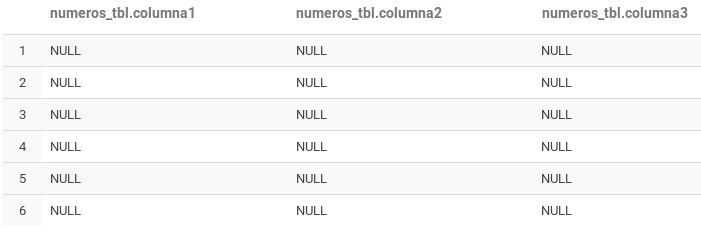
    
Si creamos la tabla de la siguiente forma:
   
    CREATE EXTERNAL TABLE numeros_tbl(
    columna1 int,
    columna2 int,
    columna3 int)
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '/user/cloudera/test';
Y los ficheros que hay en la ruta indicada están guardados con el formato introducido en la creación de la tabla, obtendremos el siguiente resultado:    

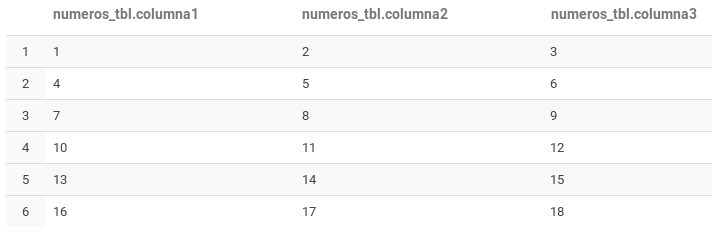
